In [ ]:
#Import necessary tools needed for the project
!pip install split-folders        #tool for creating training/validation/test folders
import tensorflow as tf     #tensorflow framework
from tensorflow.keras import layers, models, optimizers     #necessary tools from keras API to build the model
 
import os           #for working with folders 
import zipfile      #for working with zif file
import splitfolders #as above
 
from tensorflow.keras.preprocessing.image import ImageDataGenerator     #tools for image processing and data augmentation

The following python code will use the OS library to use Operating System libraries, giving access to the file system, and the zipfile library allowing to unzip the data. 

In [ ]:
local_zip = '/dataset.zip'      #folder location of zip dataset provided

zip_ref = zipfile.ZipFile(local_zip, 'r')

#extract the zip file containing all the pictures of the dataset in the given directory
zip_ref.extractall('/content/dataset1')
zip_ref.close()

Now let's create a training and validation folders and splitting of the given data so we can train and test the model later on.

In [ ]:
splitfolders.ratio('/content/dataset1', output="/content/train_val", seed=1337, ratio=(0.8,0.2)) 


Copying files: 300 files [00:00, 4577.65 files/s]


In the following cell will create the model architecture using a simple sequential API.




In [ ]:
def create_model():
  model = models.Sequential([
  #Conv2D  layer for performing convolution on image, 32 filters, stride= 3 by 3, relu activation and input shape I have
  #choose at 500 by 350 (a bit less than the original image size) at 3 RGB channels
  #I have choosen this image input beccause the bigger the image the more features can be exctracted and since
  #there are only  a handful images we should use every valuable info from them
  layers.Conv2D(32, (3, 3), activation='relu', input_shape=(500, 350, 3)),
  #A maxpooling layer serves to reduction of parameters and compression 
  #Batchnormaliation layer  helps normalizing the parameters
  #so the gradient descent can be more optimal in the process
  tf.keras.layers.BatchNormalization(),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(64, (3, 3), activation='relu'),
  #Batchnormaliation layer  helps normalizing the parameters
  #so the gradient descent can be more optimal in the process
  tf.keras.layers.BatchNormalization(),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(64, (3, 3), activation='relu'),
  tf.keras.layers.BatchNormalization(),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(128, (3, 3), activation='relu'),
  tf.keras.layers.BatchNormalization(),
  layers.MaxPooling2D((2, 2)),
  #The flatten layer prepares the convolution outputs for a dense layer
  layers.Flatten(),
  layers.Dense(512, activation='relu'),
  #Activation in the last dense layer is softmax since we have three classes
  layers.Dense(3, activation='softmax')
  ])
 
 
  # Compile the model, loss is used SparseCategoricalCrossentropy since we have 3 outputs
  #The optimizer I have used is Adam and learning rate according to tests is most optimal at lr= 3e-4 but can be changed
  model.compile(
      loss=tf.keras.losses.SparseCategoricalCrossentropy(),
      optimizer=optimizers.Adam(learning_rate=3e-4),
      metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
  )
 
  return model

In [ ]:
# Create a model to use with the dataset
model = create_model()

# Print the model's summary
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 498, 348, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 498, 348, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 249, 174, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 247, 172, 64)      18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 247, 172, 64)      256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 123, 86, 64)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 121, 84, 64)       3

In the next cell I am going to use the ImageDataGenerator from keras to augment the training data since the number of images is quite small. In the ImageDataGenerator function I am using a number of tweeks defined in the fucntion definiton in keras. No data augmentation is done for the validation set, no need since its not used for training the model performance only testing.


In [ ]:
# Now applying image augmentation
train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=50,
        width_shift_range=0.15,
        height_shift_range=0.15,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

#image normalization between 0 and 1
test_datagen = ImageDataGenerator(rescale=1./255)

# Pointing to directory with full dataset and creating a generator for feeding training and 
#validation images to the model later on
train_generator = train_datagen.flow_from_directory(
        '/content/train_val/train',
        target_size=(500, 350),
        batch_size=40,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        '/content/train_val/val',
        target_size=(500, 350),
        batch_size=20,
        class_mode='binary')

Found 240 images belonging to 3 classes.
Found 60 images belonging to 3 classes.


In [ ]:
print(f"labels for each class in the train generator are: {train_generator.class_indices}")
print(f"labels for each class in the validation generator are: {validation_generator.class_indices}")

labels for each class in the train generator are: {'animals': 0, 'buildings': 1, 'landscapes': 2}
labels for each class in the validation generator are: {'animals': 0, 'buildings': 1, 'landscapes': 2}


Now its time to train the model using model.fit and suplying the training and validation generator for 150 epochs. 

In [ ]:
history = model.fit(train_generator,
                              validation_data=validation_generator,
                              steps_per_epoch=6,
                              epochs=150,
                              validation_steps=2,
                              verbose=2)

Epoch 1/150
6/6 - 15s - loss: 15.6660 - sparse_categorical_accuracy: 0.4250 - val_loss: 1.2574 - val_sparse_categorical_accuracy: 0.3250
Epoch 2/150
6/6 - 9s - loss: 5.1276 - sparse_categorical_accuracy: 0.4625 - val_loss: 1.6688 - val_sparse_categorical_accuracy: 0.3500
Epoch 3/150
6/6 - 9s - loss: 1.7233 - sparse_categorical_accuracy: 0.5750 - val_loss: 1.8196 - val_sparse_categorical_accuracy: 0.2250
Epoch 4/150
6/6 - 9s - loss: 1.1922 - sparse_categorical_accuracy: 0.6375 - val_loss: 2.8258 - val_sparse_categorical_accuracy: 0.3000
Epoch 5/150
6/6 - 9s - loss: 1.3863 - sparse_categorical_accuracy: 0.6375 - val_loss: 2.8476 - val_sparse_categorical_accuracy: 0.4500
Epoch 6/150
6/6 - 9s - loss: 1.0743 - sparse_categorical_accuracy: 0.6750 - val_loss: 3.3311 - val_sparse_categorical_accuracy: 0.4750
Epoch 7/150
6/6 - 9s - loss: 0.8239 - sparse_categorical_accuracy: 0.7708 - val_loss: 4.1064 - val_sparse_categorical_accuracy: 0.2500
Epoch 8/150
6/6 - 9s - loss: 0.6682 - sparse_categori

Let's plot the training/validation accuracy and loss as collected during training:

Text(0.5, 1.0, 'Training and validation loss')

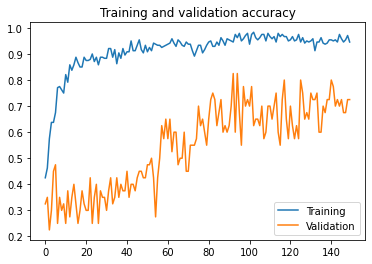

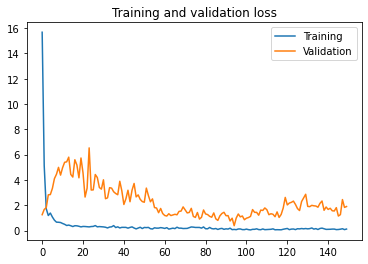

In [ ]:
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt


# Retrieve a list of list results on training and test data
# sets for each training epoch

acc      = history.history[    'sparse_categorical_accuracy' ]
val_acc  = history.history[ 'val_sparse_categorical_accuracy' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]

epochs   = range(len(acc)) #number of epochs

# Plot training and validation accuracy per epoch

plt.plot  ( epochs,     acc, label='Training')
plt.plot  ( epochs, val_acc, label='Validation')
plt.title ('Training and validation accuracy')
plt.legend()
plt.figure()

# Plot training and validation loss per epoch

plt.plot  ( epochs,     loss, label='Training')
plt.plot  ( epochs, val_loss, label='Validation')
plt.legend()
plt.title ('Training and validation loss')